## Семинар 9: "LSTM"

ФИО: Личманов Дмитрий Игоревич

In [68]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch import optim
import torch
from torch import nn
import pandas
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.autograd import Variable
%matplotlib inline

Этот семинар посвящен реализации RNN в pyTorch

## Задание 1

Напишите свою реализацию LSTM.

<img src="https://cdn-images-1.medium.com/max/1600/1*hl9UVtgIcQkDIGD8VFykdw.png" width="640">

In [69]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gate_size = 4 * self.hidden_size
        
        self.W_i = nn.Parameter(torch.Tensor(input_size, self.gate_size).zero_())
        
        self.W_h = nn.Parameter(torch.Tensor(hidden_size, self.gate_size).zero_())
        
        self.b = nn.Parameter(torch.Tensor(self.gate_size).zero_())
        
        
    def forward(self, inputs, hidden):
        # inputs: (seq_len, batch_size, input_size)
        # hidden: (batch_size, hidden_size) x 2. (no layers)
        
        h, c = hidden
        bs = h.size(0)
        
        seq_length = inputs.size(0)
        out = Variable(torch.Tensor(seq_length, bs, self.hidden_size))
        
        for i, inp in enumerate(inputs):
            S = (torch.matmul(inp, self.W_i) + torch.matmul(h, self.W_h) + self.b)
            S = S.view(bs, 4, self.hidden_size)
            
            i_1 = torch.sigmoid(S[:,0,:])
            f_1 = torch.sigmoid(S[:,1,:])
            g_1 = torch.tanh(S[:,2,:])
            o_1 = torch.sigmoid(S[:,3,:])
            
            c = f_1 * c + i_1 * g_1
            h = o_1 * torch.tanh(c)
            out[i] = h
        return out, (h, c)

In [ ]:
a = torch.Tensor(2,3,4)
b = torch.Tensor(4,2)
c = torch.matmul(a,b)
c.shape

torch.Size([2, 3, 2])

In [ ]:
torch.matmul(b,a)

tensor([nan, 0., 0., 0.])

## Задание 2

Используя свою реализацию LSTM и torch.nn.LSTM (torch.nn.GRU) решить задачу предсказания временного ряда.
Попробуйте разные длины входной и выходной последовательности.
С помощью обученной сети получить из train-части временного ряда test-часть.

Данные о количестве пассажиров
https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line

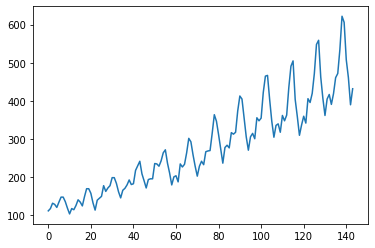

In [108]:
%matplotlib inline
dataset = pandas.read_csv('international-airline-passengers.csv', usecols=[1], delimiter=";", engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

In [109]:
dataset.shape

(144, 1)

In [110]:
# подготовливаем данные

dataset = dataset.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)


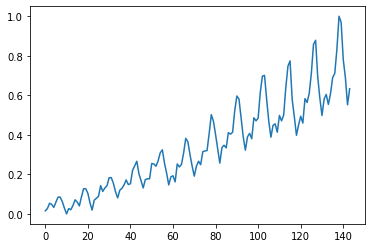

In [111]:
plt.plot(dataset)
plt.show()

In [112]:
# разбиваем данные на train / test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

96 48


In [113]:
# Целевая переменная - сдвинутая последовательность значений входов

def create_dataset(dataset, look_back=1, look_forward=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1-look_forward):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back : (i + look_back + look_forward), 0])

    return np.array(dataX), np.array(dataY)

In [114]:
train.shape

(96, 1)

In [115]:
# Пример подготовленных данных

look_back = 1
look_forward = 1
trainX, trainY = create_dataset(train, look_back, look_forward)
testX, testY = create_dataset(test, look_back, look_forward)

In [116]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(93, 1)
(93, 1)
(45, 1)
(45, 1)


In [117]:
train_dataset = TensorDataset(torch.from_numpy(trainX), torch.from_numpy(trainY))

In [118]:
train_dataloader =  DataLoader(train_dataset, batch_size = 1)

In [119]:
test_dataset = TensorDataset(torch.from_numpy(testX), torch.from_numpy(testY))

In [120]:
test_dataloader = DataLoader(test_dataset,batch_size = 1)

In [130]:
class LSTM_Wrapper(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()

        self.hidden_layer_size = hidden_layer_size
        #Use custom version of LSTM cell 
        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        # Saved cell
        self.hidden_cell = (torch.zeros(1,1, hidden_layer_size),
                            torch.zeros(1,1, hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq, self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [131]:
model = LSTM_Wrapper()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [132]:
epochs = 150

for i in range(epochs):
    for seq, labels in train_dataloader:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        seq = seq[:,None,:]
        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%5 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch:   1 loss: 0.00105877
epoch:   6 loss: 0.00835615
epoch:  11 loss: 0.01017837
epoch:  16 loss: 0.01031162
epoch:  21 loss: 0.01039026
epoch:  26 loss: 0.01043265
epoch:  31 loss: 0.01044653
epoch:  36 loss: 0.01044014
epoch:  41 loss: 0.01041977
epoch:  46 loss: 0.01041222
epoch:  51 loss: 0.01035279
epoch:  56 loss: 0.01033976
epoch:  61 loss: 0.01026506
epoch:  66 loss: 0.01022153
epoch:  71 loss: 0.01017000
epoch:  76 loss: 0.01013896
epoch:  81 loss: 0.01007177
epoch:  86 loss: 0.01002565
epoch:  91 loss: 0.00996908
epoch:  96 loss: 0.00991941
epoch: 101 loss: 0.00986269
epoch: 106 loss: 0.00980869
epoch: 111 loss: 0.00975608
epoch: 116 loss: 0.00970382
epoch: 121 loss: 0.00965139
epoch: 126 loss: 0.00960122
epoch: 131 loss: 0.00955244
epoch: 136 loss: 0.00950503
epoch: 141 loss: 0.00945634
epoch: 146 loss: 0.00940856
epoch: 149 loss: 0.0093811015


In [133]:
test_dataloader

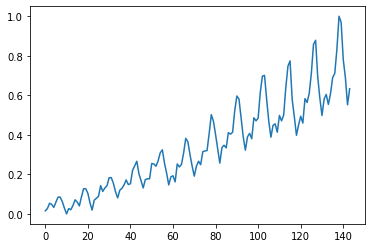

In [134]:
plt.plot(dataset)
plt.show()

In [137]:
predictions = []
start_point = trainX.shape[0]
months = []
for seq, labels in test_dataloader:
        seq = seq[:,None,:]
        y_pred = model(seq)
        months.append(start_point)
        start_point += 1
        predictions.append(y_pred)

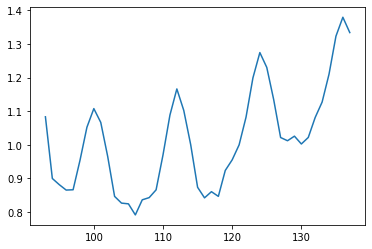

In [138]:
plt.plot(months, predictions)

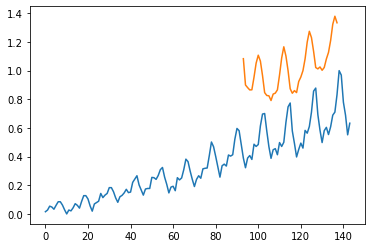

In [139]:
plt.plot(dataset)
plt.plot(months, predictions)
plt.show()

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: